## Import

In [26]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import pathlib

# TensorBoard callback
import datetime

## Functions

In [2]:
# Create a transfer learning model from a URL
def create_transfer_learning_model(model_url, input_shape, num_classes=10, trainable=False):
  feature_extractor_layer = hub.KerasLayer(
    model_url,
    trainable=trainable,
    name='feature_extraction_layer',
    input_shape=input_shape
  )

  model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [3]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [4]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [5]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [27]:
def view_random_image(target_dir, class_name=""):
  target_folder = target_dir + '/' + class_name
  
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_folder)
  plt.axis('off')

  print(f"Image shape: {img.shape}")

  return img

In [7]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Download the dataset

In [19]:
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'

zip_dir = tf.keras.utils.get_file(origin=url, extract=True)
zip_dir

'C:\\Users\\bruce\\.keras\\datasets\\10_food_classes_10_percent.zip'

```
# File structure
pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

In [20]:
base_dir = os.path.join(os.path.dirname(zip_dir), '10_food_classes_10_percent')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# train_pizza_dir = os.path.join(train_dir, 'pizza')  # directory with our training pizza pictures
# train_steak_dir = os.path.join(train_dir, 'steak')  # directory with our training steak pictures
# test_pizza_dir = os.path.join(test_dir, 'pizza')  # directory with our test pizza pictures
# test_steak_dir = os.path.join(test_dir, 'steak')  # directory with our test steak pictures

# num_pizza_tr = len(os.listdir(train_pizza_dir))
# num_steak_tr = len(os.listdir(train_steak_dir))

# num_pizza_test = len(os.listdir(test_pizza_dir))
# num_steak_test = len(os.listdir(test_steak_dir))

# total_train = num_pizza_tr + num_steak_tr
# total_test = num_pizza_test + num_steak_test

# print('total training pizza images:', num_pizza_tr)
# print('total training steak images:', num_steak_tr)

# print('total test pizza images:', num_pizza_test)
# print('total test steak images:', num_steak_test)
# print("--")
# print("Total training images:", total_train)
# print("Total test images:", total_test)

# print("--")
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [21]:
walk_through_dir(base_dir)

There are 2 directories and 0 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent'.
There are 10 directories and 0 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datas

['1801809.jpg']
Image shape: (512, 512, 3)


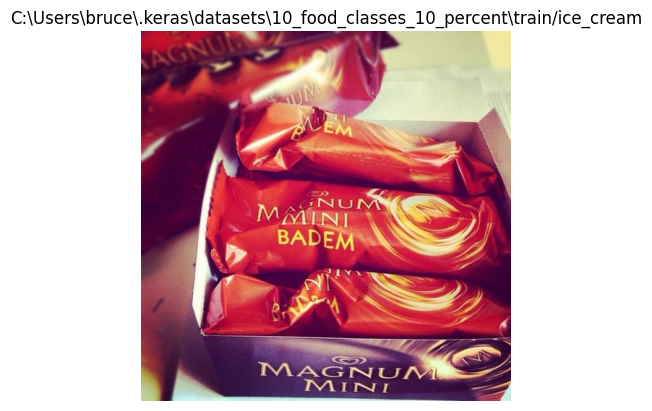

In [31]:
rand_img = view_random_image(target_dir=train_dir, class_name='ice_cream')

## Set ImageDataGenerator with augmentation

Found 750 images belonging to 10 classes.


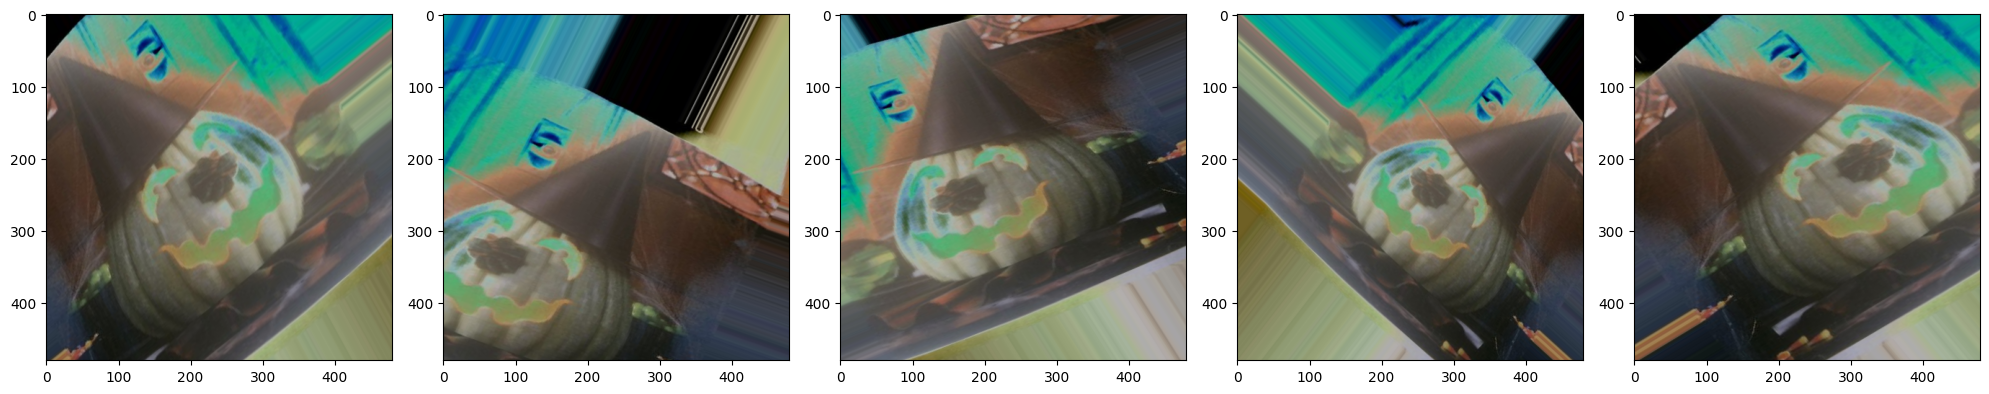

In [10]:
BATCH_SIZE = 32
IMG_SHAPE  = 480

image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_batches = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE)
)

augmented_images = [train_batches[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_batches = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE)
)

Found 2500 images belonging to 10 classes.


## Build a model with Transfer Learning

### imagenet/resnet_v2_50/feature_vector:
expected size in (224, 224, 3)\
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

### efficientnet/b0/feature-vector:
accept various size but best match for (224, 224, 3)\
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

### imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector
expected size in (480, 480, 3)\
https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2

In [12]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
effnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
effnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2'

### ResNet50v2 model

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

resnet_model = create_transfer_learning_model(resnet_url, (IMG_SHAPE, IMG_SHAPE, 3), num_classes=len(class_names))

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

tersorboard_callback = create_tensorboard_callback(
    dir_name='tensorboard',
    experiment_name='ResNet_v2_50'
)

resnet_history =  resnet_model.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches,
    callbacks=[tersorboard_callback]
)

Saving TensorBoard log files to: tensorflow_hub/resnet_v2_50/20230408-203157
Epoch 1/10
24/24 [==============================] - 39s 1s/step - loss: 1.9873 - accuracy: 0.3227 - val_loss: 1.2851 - val_accuracy: 0.5824
Epoch 2/10
24/24 [==============================] - 22s 917ms/step - loss: 1.1655 - accuracy: 0.6307 - val_loss: 0.9152 - val_accuracy: 0.6984
Epoch 3/10
24/24 [==============================] - 23s 973ms/step - loss: 0.8715 - accuracy: 0.7133 - val_loss: 0.8078 - val_accuracy: 0.7284
Epoch 4/10
24/24 [==============================] - 22s 934ms/step - loss: 0.7701 - accuracy: 0.7520 - val_loss: 0.7319 - val_accuracy: 0.7576
Epoch 5/10
24/24 [==============================] - 22s 937ms/step - loss: 0.6532 - accuracy: 0.7867 - val_loss: 0.7076 - val_accuracy: 0.7636
Epoch 6/10
24/24 [==============================] - 22s 931ms/step - loss: 0.6275 - accuracy: 0.7933 - val_loss: 0.6842 - val_accuracy: 0.7656
Epoch 7/10
24/24 [==============================] - 22s 931ms/step -

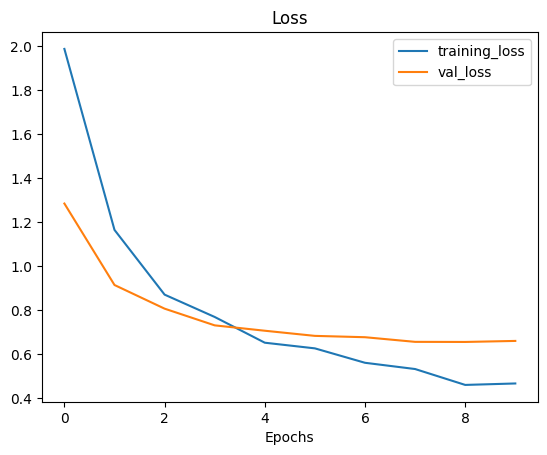

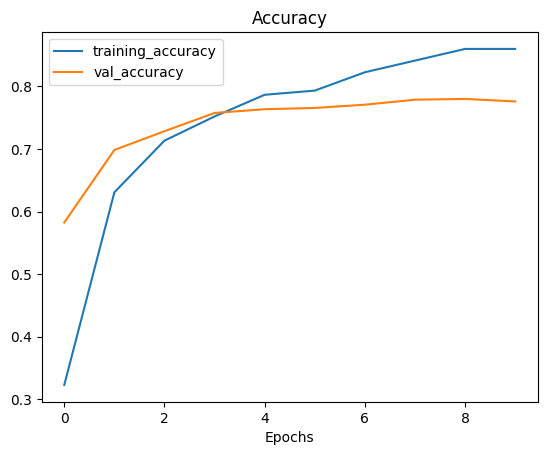

In [29]:
plot_loss_curves(resnet_history)

### EfficientNetB0 model

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

effnet_model = create_transfer_learning_model(effnet_url, (IMG_SHAPE, IMG_SHAPE, 3), num_classes=len(class_names))

effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

tersorboard_callback = create_tensorboard_callback(
    dir_name='tensorboard',
    experiment_name='EfficientNet_B0'
)

effnet_history =  effnet_model.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches,
    callbacks=[tersorboard_callback]
)

Saving TensorBoard log files to: tensorflow_hub/effnet_v2_50/20230408-204014
Epoch 1/10
24/24 [==============================] - 32s 905ms/step - loss: 1.9322 - accuracy: 0.4000 - val_loss: 1.4112 - val_accuracy: 0.6828
Epoch 2/10
24/24 [==============================] - 18s 777ms/step - loss: 1.2693 - accuracy: 0.6867 - val_loss: 0.9491 - val_accuracy: 0.7968
Epoch 3/10
24/24 [==============================] - 19s 797ms/step - loss: 0.9495 - accuracy: 0.7627 - val_loss: 0.7562 - val_accuracy: 0.8224
Epoch 4/10
24/24 [==============================] - 20s 824ms/step - loss: 0.7914 - accuracy: 0.8040 - val_loss: 0.6621 - val_accuracy: 0.8376
Epoch 5/10
24/24 [==============================] - 20s 835ms/step - loss: 0.6935 - accuracy: 0.8373 - val_loss: 0.6000 - val_accuracy: 0.8496
Epoch 6/10
24/24 [==============================] - 19s 816ms/step - loss: 0.6200 - accuracy: 0.8453 - val_loss: 0.5616 - val_accuracy: 0.8508
Epoch 7/10
24/24 [==============================] - 19s 819ms/ste

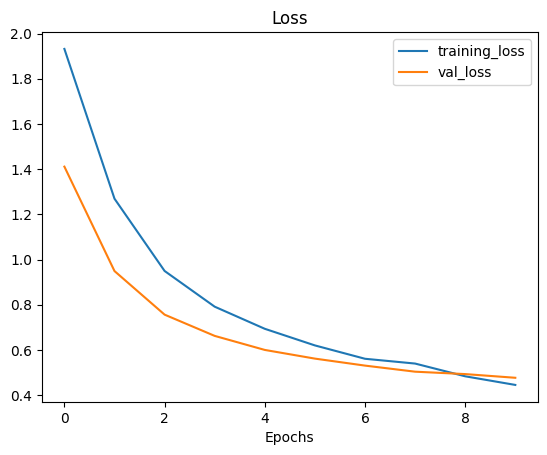

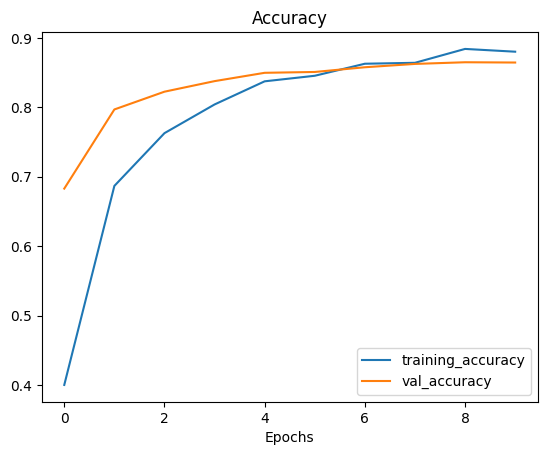

In [31]:
plot_loss_curves(effnet_history)

### EfficientNet_V2 model

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

effnet_v2_model = create_transfer_learning_model(effnet_v2_url, (IMG_SHAPE, IMG_SHAPE, 3), num_classes=len(class_names))

effnet_v2_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

tersorboard_callback = create_tensorboard_callback(
    dir_name='tensorboard',
    experiment_name='EfficientNet_v2'
)

effnet_v2_history =  effnet_v2_model.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches,
    callbacks=[tersorboard_callback]
)

Saving TensorBoard log files to: tensorflow_hub/EfficientNet_v2/20230408-215639
Epoch 1/5
24/24 [==============================] - 217s 8s/step - loss: 1.7193 - accuracy: 0.4480 - val_loss: 0.8283 - val_accuracy: 0.8380
Epoch 2/5
24/24 [==============================] - 198s 8s/step - loss: 0.6131 - accuracy: 0.8613 - val_loss: 0.4115 - val_accuracy: 0.9236
Epoch 3/5
24/24 [==============================] - 365s 16s/step - loss: 0.3727 - accuracy: 0.9093 - val_loss: 0.2887 - val_accuracy: 0.9400
Epoch 4/5
24/24 [==============================] - 569s 24s/step - loss: 0.2785 - accuracy: 0.9467 - val_loss: 0.2605 - val_accuracy: 0.9440
Epoch 5/5
24/24 [==============================] - 569s 24s/step - loss: 0.2341 - accuracy: 0.9467 - val_loss: 0.2129 - val_accuracy: 0.9492


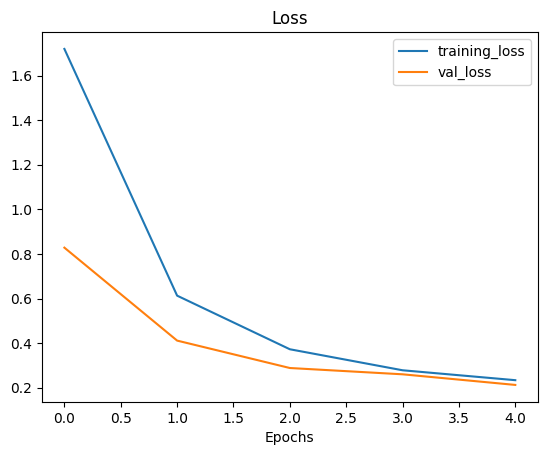

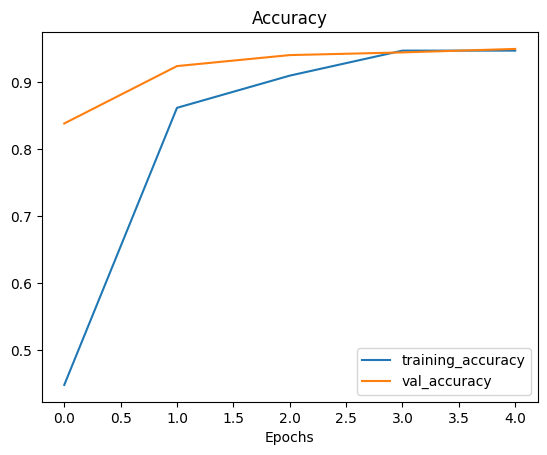

In [14]:
plot_loss_curves(effnet_v2_history)